# Cleaning Notebook 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
%matplotlib inline
path = './data/'

def load_data(filepath):
    '''This function loads a dataset, creates a valid date column, and reshuffles the columns.'''
    data = pd.read_csv(filepath).drop('Unnamed: 0', 1)
    #Convert date column into a "real" date column, not a floating number
    data['date'] = data['date'].astype(int).astype(str)
    data['date'] = pd.to_datetime(data['date']).dt.date

    #Reshuffle columns so that date, hour, type are at the front
    observation_cols = list(data.columns.values[:-3])
    cols = list(data.columns.values[-3:])
    cols.extend(observation_cols)
    DF = data[cols]
    return DF

def remove_and_rename_columns(DF, list_of_stations, list_of_metros):
    '''This function removes station data that will not be used in our model.
    @list_of_stations: a list of stations that we want to keep!
    Function also renames columns so that they are named after metro areas, not station codes
    '''
    cols = ['date', 'month', 'weekday', 'hour']
    stations = [x for x in list_of_stations]
    cols.extend(stations)
    new_DF = DF[cols]
    for m in range(len(list_of_metros)):
        new_DF = new_DF.rename(columns={list_of_stations[m]:list_of_metros[m]})        
    return new_DF

In [ ]:
PM = load_data(path+'PM2point5.csv')
PM.head()

###### The data is hourly, but some hours are "missing" throughout the entire dataset. 
For example, there are zero records for 16:00 on 2014-05-13 -- that hour is completely blank for all stations. 

To apply time series models effectively, it would be nice to "standardize" the dataset so that all records are equally spaced apart. For example, without 16:00 on May 13, the gap between 15:00 and the preceding record (14:00) will be larger than the gap between 15:00 and the subsequent record (17:00). This is a problem. 

To address this problem, we'll construct a formal "Times" dataframe where ALL hours between May 13, 2014 and December 31, 2016 are represented. We'll merge this "Times" dataframe with the PM2.5 dataframe. Then, we will need to estimate missing PM 2.5 values for the empty hours (newly introduced by the "Times" df.

In [ ]:
def merge_times(DF, start_date, end_date):
    '''This function constructs a "Times" dataframe where each row represents one hour. 
    Ultimately, we want to ensure that our DF with PM2.5 data has no missing hours. 
    
    @start_date should be in format datetime.date(2014, 5, 13)
    @end_date should be datetime.date(2017, 1, 1) (if you want all hourly data in 2016)
    '''
    Times = pd.DataFrame(pd.date_range(start_date, end_date, freq='H')[:-1]).rename(columns={0: 'Time'})
    Times['date'] = Times['Time'].dt.date
    Times['hour'] = Times['Time'].dt.hour
    Times['month'] = Times['Time'].dt.month
    Times['weekday'] = Times['Time'].dt.weekday
    Times = Times.drop('Time',1)

    ### Merge PM and Times dataframes together 
    DF_new = DF.merge(Times, on=['date', 'hour'], how='right')
    DF_new = DF_new.sort_values(by=['date','hour']).reset_index(drop=True)
    return DF_new

In [ ]:
PM = merge_times(PM, datetime.date(2014, 5, 13), datetime.date(2017, 1, 1))
PM.head()

### To make computations simpler, only take stations from 21 metro areas.
For each metro area, pick station with highest number of observations. See "stations" notebook for more details

In [7]:
metro_codes = pd.read_csv(path+'Station_Metro_Codes.csv')
metro_codes = metro_codes.drop('Unnamed: 0', 1)
stations_to_use = list(metro_codes['StationID'])
metro_codes

,StationID,Metro
0,1589A,Baotou
1,1012A,Beijing
2,1342A,Changsha
3,1434A,Chengdu
4,1419A,Chongqing
5,1282A,Fuzhou
6,1349A,Guangzhou
7,1129A,Harbin
8,1453A,Kunming
9,1456A,Lhasa


### Deal with missing observations: 

**Strategy: For any missing observation, take a weighted average of the most immediate (recorded) prior observation and most immediate (recorded) future observation.** The weights are based on how far away the recorded observations are from the missing observation. For example, let's say we are missing AQI data for 4:00am and 5:00am, but we know that AQI = 30 at 3:00am and AQI = 60 at 6:00am. Instead of simply plugging in the unweighted average AQI value (AQI = 45) for both hours, the code below will produce AQI = 40 for 4:00am and AQI = 50 for 5:00am. For the 4:00am missing value, twice as much weight is placed on the 3:00am recorded value than the 6:00am recorded value, resulting in a weighted average of (2/3 x 30)  + (1/3 x 60) = 40.  

In [ ]:
def fill_missing_obs(DF, StationID):
    '''This function fills missing values for a particular station
    @StationID: string format -- equivalent to column name
    @DF: dataframe
    '''
    DF['missing_'+StationID] = np.where(DF[StationID]>-99, 0, 1)
    missing = DF[DF['missing_'+StationID]==1]
    
    first_nonzero = [x for x in np.arange(20) if x not in missing.index][0]
    last_nonzero = [x for x in np.arange(len(DF)-20, len(DF), 1) if x not in missing.index][-1]
    
    for x in missing.index: #For each missing cell
        if x < first_nonzero:
            pass
        elif x > last_nonzero:
            pass

        else:
            non_missing_prior_index = x-1 #Find most recent past record 
            non_missing_post_index = x+1  
    
            while True:
                if non_missing_prior_index in missing.index:
                    non_missing_prior_index = non_missing_prior_index - 1
                else:
                    break
        
            while True:
                if non_missing_post_index in missing.index:
                    non_missing_post_index = non_missing_post_index + 1
                else:
                    break

            prior_datapoint = DF.loc[non_missing_prior_index, StationID] 
            post_datapoint = DF.loc[non_missing_post_index, StationID]

            priordiff = x - non_missing_prior_index
            postdiff = non_missing_post_index - x
            diff = priordiff + postdiff
            prior_weight = postdiff/diff
            post_weight = priordiff/diff
    
            DF.loc[x, StationID] = (prior_weight*prior_datapoint) + (post_weight*post_datapoint) 
    
    #else if x == 0 or x == len(DF)-1
    DF[StationID] = DF[StationID].fillna(method = 'ffill').fillna(method = 'bfill') 
    DF = DF.drop('missing_'+StationID, 1)
    return DF

## Interpolate missing observations, and remove stations that aren't in the 21 cities listed above. 

In [8]:
stations_to_use = list(metro_codes['StationID'])
metros_to_use = list(metro_codes['Metro'])

for s in stations_to_use:
    PM = fill_missing_obs(PM, s)

PM_less = remove_and_rename_columns(PM, stations_to_use, metros_to_use)
PM_less.head()

NameError: name 'fill_missing_obs' is not defined

-----

# Add Weather Features 

In [ ]:
def load_weather_data(city_name):
    '''This function loads weather data for a particular city'''
    
    weather_path = './weather_data/'
    WeatherDF = pd.read_csv(weather_path+city_name+'.csv', usecols=['date', 'hour', 'Humidity',
                                                           'Wind Dir', 'Wind Speed',
                                                            'Temp.', 'Pressure'], encoding='latin1' )
    #Convert date into a datetime variable
    WeatherDF['date'] = pd.to_datetime(WeatherDF['date']).dt.date

    #Convert temperature into a numerical variable
    WeatherDF['Temp.'] = WeatherDF['Temp.'].str.replace('åÊå¡F', '').astype(float)

    #Convert humidity into a numerical variable.
    WeatherDF['Humidity'] = WeatherDF['Humidity'].str.replace('%', '').astype(float)

    #Convert pressure into a numerical variable
    WeatherDF['Pressure'] = WeatherDF['Pressure'].str.replace('åÊin','').astype(float)

    #Convert wind speed into a numerical variable
    WeatherDF['Wind Speed'] = WeatherDF['Wind Speed'].str.replace('åÊmph','')
    WeatherDF['Wind Speed'] = np.where(WeatherDF['Wind Speed'] == 'Calm', 0, WeatherDF['Wind Speed']).astype(float)
    return WeatherDF    

In [ ]:
BeijingW = load_weather_data('Beijing')
BeijingW.head()

In [ ]:
#One tricky variable is wind direction
BeijingW.groupby('Wind Dir').count()[['date']].sort_values(by='date').T

In [ ]:
#Convert wind direction into a numerical variable
#NOTE: indexed at 0 = WEST -- historically wind rarely comes from the West in Beijing (see chart above)
wind_direction = {'North': 90, 'NNE':112.5, 'NE': 135, 'ENE': 157.5, 
                  'East': 180, 'ESE':202.5, 'SE': 225, 'SSE': 247.5,
                  'South': 270,'SSW': 292.5, 'SW': 315, 'WSW': 337.5,
                  'West': 0, 'WNW': 22.5, 'NW': 45, 'NNW': 67.5,
                 'Variable': None, 'Calm': None}

BeijingW['wind_angle'] = BeijingW['Wind Dir'].map(lambda x: wind_direction[x])
BeijingW = BeijingW.drop('Wind Dir', 1)

#Merge times
BeijingWeather = merge_times(BeijingW, datetime.date(2014, 5, 13), datetime.date(2017, 1, 1))
BeijingWeather.tail()

### Fill in blanks for weather data

In [ ]:
#same method to fill missing observations
for c in ['Humidity', 'Pressure', 'Temp.', 'Wind Speed']:
    BeijingWeather = fill_missing_obs(BeijingWeather, c)

#For wind_angle, just use the most recent prior observation.
#For most nulls for wind_angle, wind speed is very low (0-2mph), so not too concerned.
#Didn't use fill_missing_obs function because of the circular nature of the wind_angle variable.
#(Jump from 315 to 45 degrees is tricky)

BeijingWeather['wind_angle'] = BeijingWeather['wind_angle'].fillna(method='ffill')
BeijingWeather.tail()

------

### Merge weather data to create final (hourly) dataset 

In [ ]:
PM_Hour = PM_less.merge(BeijingWeather, on=['date','hour', 'month', 'weekday'])
PM_Hour.to_csv('PM25_Hour.csv')

### Create final (daily) dataset as well 

In [ ]:
PM_Day = PM_Hour.groupby('date', as_index=False).mean() #Take daily average of each variable.
PM_Day.to_csv('PM25_Day.csv')

In [2]:
PM_Day=pd.read_csv('/Users/zachariah.zhang/Downloads/PM25_Day.csv')
PM_Hour=pd.read_csv('/Users/zachariah.zhang/Downloads/PM25_Hour.csv')

----------

# Build Random Forests Model

Will require hard-coding variables.

# Autoregressive Features

For this task, we want to predict pollution levels far into the future (at least one day away). Therefore, in terms of autoregressive features, we will only use values that occur at least 24 hours in the past. 

In [3]:
def add_autoregressive_features(DF, Metro, time_steps):
    '''@time_steps: a list of integers indicating which autoregressive values to use
    e.g. [24, 36] means to use the observations from 24 hours ago and 36 hours ago
    '''
    for t in time_steps:
        lagged_values = np.empty(t)
        lagged_values[:] = np.nan
        lagged_values = list(lagged_values)
        lagged_values.extend(list(DF[Metro][:-t]))
        DF[Metro+' t-'+str(t)] = lagged_values
    return DF


time_steps = [24, 36, 48]
day_steps = [1, 2]
BeijHour = add_autoregressive_features(PM_Hour.copy(), 'Beijing', time_steps)
BeijDay = add_autoregressive_features(PM_Day.copy(), 'Beijing', day_steps)

BeijHour.tail(2)

,Unnamed: 0,date,month,weekday,hour,Baotou,Beijing,Changsha,Chengdu,Chongqing,...,Yinchuan,Zhengzhou,Humidity,Pressure,Temp.,Wind Speed,wind_angle,Beijing t-24,Beijing t-36,Beijing t-48
23134,23134,2016-12-31,12,5,22.0,156.0,521.0,136.0,209.0,118.0,...,201.0,245.0,93.0,30.3,23.0,2.2,157.5,368.0,109.0,120.0
23135,23135,2016-12-31,12,5,23.0,184.0,513.0,131.0,210.0,108.0,...,202.0,250.0,93.0,30.3,21.2,2.2,157.5,278.0,116.5,109.5


# Pollution values from other stations 

In [9]:
def add_other_stations(DF, Relevant_Metros, time_steps):
    '''
    The argument 'Relevant Metros' is a list of metros that are close to the target city.
    The argument 'time_steps' is the same as in the "add_autoregressive_features" function.
    '''
    for m in Relevant_Metros:
        for t in time_steps:
            lagged_values = np.empty(t)
            lagged_values[:] = np.nan
            lagged_values = list(lagged_values)
            lagged_values.extend(list(DF[m][:-t]))
            DF[m+' t-'+str(t)] = lagged_values
    return DF   

def final_cleaning(DF, Metro):
    for m in metros_to_use:
        if m != Metro:
            DF = DF.drop(m, 1)
    return DF


BeijingHour = add_other_stations(BeijHour, ['Baotou', 'Harbin', 'Qingdao', 'Xian'], [24])
BeijingDay = add_other_stations(BeijDay, ['Baotou', 'Harbin', 'Qingdao', 'Xian'], [1])

FINAL_Hour = final_cleaning(BeijingHour, 'Beijing')
FINAL_Day = final_cleaning(BeijingDay, 'Beijing')

FINAL_Hour.tail(2)

,Unnamed: 0,date,month,weekday,hour,Beijing,Humidity,Pressure,Temp.,Wind Speed,wind_angle,Beijing t-24,Beijing t-36,Beijing t-48,Baotou t-24,Harbin t-24,Qingdao t-24,Xian t-24
23134,23134,2016-12-31,12,5,22.0,521.0,93.0,30.3,23.0,2.2,157.5,368.0,109.0,120.0,96.0,162.0,49.0,290.0
23135,23135,2016-12-31,12,5,23.0,513.0,93.0,30.3,21.2,2.2,157.5,278.0,116.5,109.5,103.0,254.0,58.0,330.0


# Modelling (Hour) 

In [ ]:
X = FINAL_Hour.drop(['Beijing','date'], 1)
y = FINAL_Hour['Beijing']

TrainX = X[48:20000]
TrainY = y[48:20000]
TestX = X[20000:]
TestY = y[20000:]

from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics

RF = RandomForestRegressor(n_estimators=20, min_samples_leaf=10)
RF.fit(TrainX, TrainY)

preds = RF.predict(TestX)
train_score = RF.score(TrainX, TrainY)
score = RF.score(TestX, TestY)

print(train_score)
print(score)

In [ ]:
RFF = pd.DataFrame(np.vstack((TrainX.columns.values, RF.feature_importances_))).T
RFF.sort_values(by=1, ascending=False)

In [ ]:
np.corrcoef(preds, TestY)

In [ ]:
plt.figure(figsize=[5,5])
plt.ylim(0,7)
plt.xlim(0,7)
plt.scatter(np.log(preds), np.log(TestY))

In [ ]:
#FinalYear = FINAL.copy()
#FinalYear['year'] = FinalYear['date'].map(lambda x: x.year)
#m = FinalYear.drop_duplicates(subset=['month','year'], keep='first')
#m.tail()

labels = ['9/1/2016', '10/1/2016', '11/1/2016', '12/1/2016']
pos = [20208, 20928, 21672, 22392]

plt.figure(figsize=(20, 10))
plt.plot(TestY, label= 'Observations')
plt.plot(np.arange(20000,23136), preds, label='Predictions')
plt.title('Hourly Predictions of Random Forest Model \n(8/23/16 to 12/31/16)', size=24)
plt.xticks(pos, labels, size=14)
plt.legend(prop={'size':20})
print()

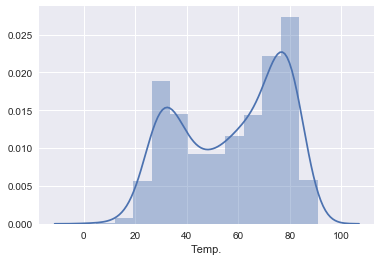

In [79]:
sns.distplot(FINAL_Day['Temp.'])

In [83]:
FINAL_Day['wind_angle'].descr

AttributeError: 'Series' object has no attribute 'summary'

In [84]:
FINAL_Day.describe()

,Unnamed: 0,month,weekday,Beijing,Humidity,Pressure,Temp.,Wind Speed,wind_angle,Beijing t-1,Beijing t-2,Baotou t-1,Harbin t-1,Qingdao t-1,Xian t-1
count,964.00000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,963.000000,962.000000,963.000000,963.000000,963.000000,963.000000
mean,481.50000,7.041494,3.000000,80.113287,57.233230,30.010584,57.605965,6.404374,155.917726,79.882377,79.780189,49.685964,54.690247,40.878570,54.227306
std,278.42713,3.326526,1.998442,68.937136,19.281725,0.301620,20.048575,3.247324,51.572376,68.598947,68.561256,33.232152,65.540850,31.370959,43.185878
min,0.00000,1.000000,0.000000,5.958333,8.916667,29.376250,4.775000,1.754167,25.312500,5.958333,5.958333,6.416667,4.166667,3.250000,5.562500
25%,240.75000,4.750000,1.000000,33.187500,42.125000,29.753229,37.550000,4.366667,120.937500,33.125000,33.062500,27.750000,17.052083,19.927083,26.770833
50%,481.50000,7.000000,3.000000,61.906250,58.229167,30.004792,61.850000,5.581250,159.375000,61.875000,61.812500,40.583333,30.458333,32.083333,41.500000
75%,722.25000,10.000000,5.000000,104.791667,72.520833,30.260625,75.950000,7.350000,194.062500,104.770833,104.713542,62.125000,68.968750,51.520833,64.843750
max,963.00000,12.000000,6.000000,519.291667,97.958333,30.838750,90.725000,22.454167,273.750000,519.291667,519.291667,274.583333,668.041667,286.125000,405.291667


# Modelling (Day) 

In [58]:
X = FINAL_Day.drop(['Beijing','date'], 1)
y = np.log(FINAL_Day['Beijing'])
mu=y.mean()
#sig=y.var()
y=y-mu
#y=(y-mu)/sig

TrainX = X[2:842]
TrainY = y[2:842]
TestX = X[842:]
TestY = y[842:]

from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics

RF = RandomForestRegressor(n_estimators=200, min_samples_leaf=5,random_state=25)
RF.fit(TrainX, TrainY)

preds = RF.predict(TestX)
train_score = RF.score(TrainX, TrainY)
score = RF.score(TestX, TestY)

print(train_score)
print(score)

0.884258765481839
0.7646909102683164


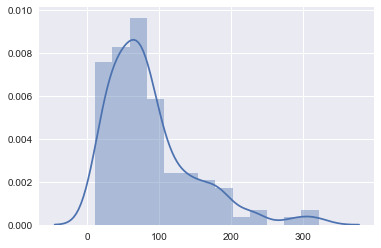

In [61]:
sns.distplot(np.exp(preds+mu))

In [62]:
r2_score(np.exp(TestY+mu),np.exp(preds+mu))

0.697656648774359

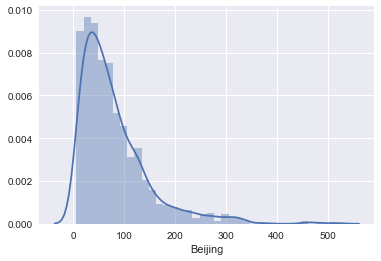

In [56]:
sns.distplot(FINAL_Day['Beijing'])

In [22]:
from sklearn.metrics import *

In [23]:
r2_score(TestY,RF.predict(TestX))

0.7647188786826024

In [24]:
r2_score(np.exp(TestY),np.exp(RF.predict(TestX)))

0.6586751171650396

In [12]:
np.histogram(y)

(array([ 26,  53,  67, 115, 180, 202, 181,  87,  46,   7]),
 array([1.7847908 , 2.23155829, 2.67832578, 3.12509327, 3.57186076,
        4.01862825, 4.46539574, 4.91216323, 5.35893072, 5.80569821,
        6.2524657 ]))

In [ ]:
RFF = pd.DataFrame(np.vstack((TrainX.columns.values, RF.feature_importances_))).T
RFF.sort_values(by=1, ascending=False)

In [ ]:
np.corrcoef(preds, TestY)[0,1]**2

In [ ]:
plt.figure(figsize=[5,5])
plt.ylim(0,7)
plt.xlim(0,7)
plt.scatter(np.log(preds), np.log(TestY))

In [ ]:
plt.figure(figsize=[5,5])
plt.ylim(0,500)
plt.xlim(0,500)
plt.xlabel('Predicted Daily Average PM2.5', size=14)
plt.ylabel('Observed PM2.5', size=14)
plt.title('Predictions vs. Observed\n(Daily Averages - Test Set)', size=18)
plt.scatter(preds, TestY)

In [ ]:
#FinalYear = FINAL_Day.copy()
#FinalYear['year'] = FinalYear['date'].map(lambda x: x.year)
#m = FinalYear.drop_duplicates(subset=['month','year'], keep='first')
#m.tail()

labels = ['9/1/2016', '10/1/2016', '11/1/2016', '12/1/2016']
pos = [842, 872, 903, 933]

plt.figure(figsize=(20, 10))
plt.plot(TestY, label= 'Observations')
plt.plot(np.arange(833, 964), preds, label='Predictions')
plt.title('Daily Predictions of Random Forest Model \n(8/23/16 to 12/31/16)', size=24)
plt.xticks(pos, labels, size=14)
plt.legend(prop={'size':20})
print()

#  RNN

In [66]:
import pandas as pd
import seaborn as sns
from tstoolbox.tstoolbox import fill
import numpy as np
from dateutil.parser import parse
import datetime
from sklearn.linear_model import LinearRegression
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.layers.core import Lambda
from keras.layers.merge import concatenate, add, multiply
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.noise import GaussianNoise
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from keras.layers.pooling import MaxPooling1D
from keras.layers.core import Flatten
from keras.layers.wrappers import TimeDistributed
from keras.models import Sequential
import pickle
from keras import optimizers


def format_data( X , y, seq_len = 60, stride = 5):

    horizon=1
    n = X.shape[0] - seq_len - 1
    n = n // stride

    _input = np.zeros((n , seq_len, X.shape[1]))
    _output = np.zeros((n ))

    for i in range(0,n):

        if i* stride + seq_len + horizon - 1 < y.shape[0]:
            _input[i] = X[i * stride:i * stride+ seq_len]
            _output[i] = y[i* stride + seq_len + horizon - 1 ]

    return _input , _output


X_train_rnn,y_train_rnn=format_data(np.array(TrainX),np.array(TrainY),seq_len=5,stride=1)
X_test_rnn,y_test_rnn=format_data(np.array(TestX),np.array(TestY),seq_len=5,stride=1)

#y_train_rnn=np.log(y_train_rnn)
#y_test_rnn=np.log(y_test_rnn)

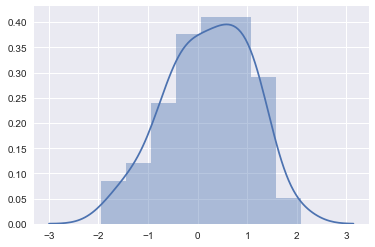

In [67]:
sns.distplot(y_test_rnn)

In [68]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train_rnn.shape[1],X_train_rnn.shape[2]),recurrent_dropout=0, return_sequences=False, stateful=False))
model.add(Dense(1 , activation='linear'))


sgd = optimizers.SGD(lr=0.1, clipnorm=1.)
adam=optimizers.Adam(lr=.001,clipnorm=1.)

#model.compile(loss='mean_squared_error' ,optimizer='adam')
model.compile(loss='mean_squared_error' ,optimizer=adam)

model.fit(X_train_rnn, y_train_rnn, batch_size=64, nb_epoch=60,
              validation_data=(X_test_rnn, y_test_rnn), shuffle=True , verbose=1)


Train on 834 samples, validate on 116 samples
Epoch 1/60
834/834 [==============================] - 1s 2ms/step - loss: 0.9822 - val_loss: 1.1234
Epoch 2/60
834/834 [==============================] - 0s 339us/step - loss: 0.8324 - val_loss: 1.0993
Epoch 3/60
834/834 [==============================] - 0s 314us/step - loss: 0.7591 - val_loss: 1.1088
Epoch 4/60
834/834 [==============================] - 0s 361us/step - loss: 0.7003 - val_loss: 1.0069
Epoch 5/60
834/834 [==============================] - 0s 412us/step - loss: 0.6591 - val_loss: 1.0387
Epoch 6/60
834/834 [==============================] - 0s 337us/step - loss: 0.6292 - val_loss: 1.1276
Epoch 7/60
834/834 [==============================] - 0s 273us/step - loss: 0.5996 - val_loss: 1.1804
Epoch 8/60
834/834 [==============================] - 0s 280us/step - loss: 0.5749 - val_loss: 1.1042
Epoch 9/60
834/834 [==============================] - 0s 252us/step - loss: 0.5503 - val_loss: 1.1371
Epoch 10/60
834/834 [=================

In [71]:
y_hat=model.predict(X_test_rnn).flatten()


In [72]:
r2_score(np.exp(y_test_rnn+mu),np.exp(y_hat+mu))

-0.2552159712073221

In [ ]:
3.89

In [ ]:
np.corrcoef(np.exp(y_hat),np.exp(y_test_rnn))[0,1]**2

In [ ]:
sns.distplot(np.log(TrainY))

# GP

In [76]:

x=np.expand_dims(np.arange(0,FINAL_Day['Beijing'].shape[0]),1)
split=842
ts=np.log(np.array(FINAL_Day['Beijing']))
mu=ts.mean()
sig=ts.var()
ts=(ts-mu)/sig

#X_train_gp=np.expand_dims(np.arange(0,TrainY.shape[0]),1)
#X_test_gp=np.expand_dims(np.arange(TrainY.shape[0],TrainY.shape[0]+TestY.shape[0]),1)

In [77]:
x.shape

(964, 1)

In [78]:
from sklearn.gaussian_process import *

y_hat=[np.array([ts[0]])]
cov=[np.array([[0]])]

for i in range(1,len(ts)):
    
    train_y = ts[:i]
    train_X = x[:i]

    test_y = ts[i]
    test_X = x[i:i+1]
    
    
    gp = GaussianProcessRegressor()
    gp.fit(train_X,train_y)

    
    pred,c = gp.predict(test_X,return_cov=True)
    y_hat.append(pred)
    cov.append(c)
    
    
test_y = ts[split:]
y_hat=np.stack(y_hat).flatten()
cov=np.stack(cov).flatten()


In [30]:
split=842

In [39]:

target=np.exp(TestY*sig+mu)
target=np.array(FINAL_Day['Beijing'])[split:]
pred=np.exp(y_hat*sig+mu)[split:]
r2_score(target,pred)

0.3545054910475719

In [73]:
np.sqrt(.35)

0.5916079783099616

In [42]:
target[split:]

array([], dtype=float64)

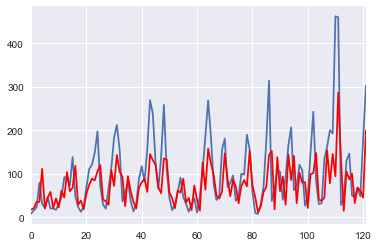

In [43]:
import seaborn as sns
%matplotlib inline

sns.tsplot(target)
sns.tsplot(pred,color='r')

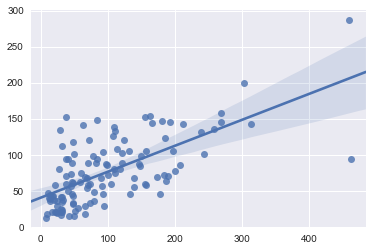

In [45]:
sns.regplot(target,pred)

In [ ]:
split

In [ ]:
M=np.exp(y_hat*sig+mu)[split+2:split+20]
S=np.zeros((M.shape[0],M.shape[0]))
np.fill_diagonal(S,np.exp(cov*sig+mu)[split+2:split+20])
#S=np.exp(cov*sig+mu)[split+2:split+20]

samples=np.random.multivariate_normal(mean=M,cov=S,size=10)

In [ ]:

n=40
m=10
t=np.arange(n-m)

target=np.exp(ts*sig+mu)[split+m:split+n]
pred=np.exp(y_hat*sig+mu)[split+m:split+n]
upper=np.exp((y_hat+cov*1.96)*sig+mu)[split+m:split+n]
lower=np.exp((y_hat-cov*1.96)*sig+mu)[split+m:split+n]


plt.title("Gaussian Process Predictions")
plt.plot(t, pred, 'r-', label=u'Prediction')
plt.fill(np.concatenate([t, t[::-1]]),
         np.concatenate([lower,
                        (upper)[::-1]]),
         alpha=.5, fc='r', ec='None', label='95% confidence interval')

plt.plot(t, target, 'b', markersize=20, label=u'Observations')


In [ ]:
#sns.set(color_codes=True)
sns.tsplot(data=samples,ci=100)


In [ ]:
np.isnan(samples).sum()

In [ ]:

plt.title('Gaussian Process Predictions')
sns.tsplot(np.exp(y_hat*sig+mu)[split+2:split+20],color='r')
sns.tsplot(np.exp((y_hat+cov)*sig+mu)[split+2:split+20],color='r')
sns.tsplot(np.exp((y_hat-cov)*sig+mu)[split+2:split+20],color='r')

sns.tsplot(np.exp(ts*sig+mu)[split+2:split+20])

In [ ]:

plt.title('Residual vs. Humidity')
plt.ylabel("Residual")
sns.regplot(FINAL_Day['Humidity'].iloc[split:],(np.exp(y_hat*sig+mu)-np.exp(ts*sig+mu))[split:])

In [ ]:
np.corrcoef(np.exp(y_hat[-133:]),np.exp(ts[split:]))

In [ ]:
X = np.array(FINAL_Day.drop(['Beijing','date'], 1))


In [ ]:
X.shape,cov.shape

In [ ]:
np.hstack([X,np.expand_dims(y_hat,1),np.expand_dims(cov,1)]).shape

In [74]:
S=[]

for i in range(20):
    X = np.array(FINAL_Day.drop(['Beijing','date'], 1))
    X=np.hstack([X,np.expand_dims(y_hat,1),np.expand_dims(cov,1)])

    y = FINAL_Day['Beijing']

    TrainX = X[2:842]
    TrainY = y[2:842]
    TestX = X[842:]
    TestY = y[842:]

    from sklearn.ensemble import RandomForestRegressor
    import sklearn.metrics

    RF = RandomForestRegressor(n_estimators=200, min_samples_leaf=5)
    RF.fit(TrainX, TrainY)

    preds = RF.predict(TestX)
    train_score = RF.score(TrainX, TrainY)
    score = RF.score(TestX, TestY)

    S.append(score)
    #print(train_score)
    #print(score)
    
print(np.array(S).mean())

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [75]:
X.shape,y_hat.shape,cov.shape

((964, 14), (116,), (964,))

In [ ]:
.698

In [ ]:
.701

--------

----

# Old Work (can ignore) 

In [ ]:
#datasets = []
#for m in metros_to_use:
#    datasets.append(add_autoregressive_features(PM_less.copy(), m))
#datasets[1].tail()


#for d in range(len(datasets)):
#    df = datasets[d]
#    if d == 1:
#        datasets[d] = add_other_stations(df.copy(), ['Baotou', 'Harbin', 'Qingdao'])
#    else:
#        datasets[d] = add_other_stations(df.copy(), metros_to_use)
#datasets[1].tail()

"""
def turn_target_into_categorical_variable(DF, StationID):
    '''
    This function turns the target variable AQI into a categorical variable with 
    three classes.
    AQI 0-100: "Excellent to Good" -- class 0
    AQI 101-200: "Lightly to Moderately Polluted" -- class 1
    AQI 200+: "Heavily Polluted" -- class 2
    '''
    DF[StationID+'_target'] = np.where(DF[StationID]>200, 2, 1) 
    DF[StationID+'_target'] = np.where(DF[StationID]<101, 0, DF[StationID+'_target'])
    return DF 
    
for d in range(len(datasets)):
    df = datasets[d]
    metro = metros_to_use[d]
    datasets[d] = datasets[d].drop('date', 1)
    #datasets[d] = final_cleaning(df.copy(), metro)
    #datasets[d] = turn_target_into_categorical_variable(datasets[d], station)
datasets[1].tail()
"""

In [ ]:
TrainXs = []
TrainYs = []
TestXs = []
TestYs = []

for d in range(len(datasets)):
    SET = datasets[d]
    StationID = metros_to_use[d]
    Train = SET[:20000]
    Test = SET[20000:]

    #Drop training observations with insufficient data (e.g. records within the first 120 hours of dataset)
    Train = Train.dropna()
    TrainX = Train.drop([StationID, StationID+'_target'], 1)
    TrainY = Train[StationID+'_target']
    TestX = Test.drop([StationID, StationID+'_target'], 1)
    TestY = Test[StationID+'_target']
    
    TrainXs.append(TrainX)
    TrainYs.append(TrainY)
    TestXs.append(TestX)
    TestYs.append(TestY)

### Baselines under classification scheme 

In [ ]:
datasets[0].groupby('1589A_target').count()[['month']]/len(datasets[0])

In [ ]:
def baselines_per_class(df, stationID):
    '''This function calculates the percentage of observations in each class (0, 1, and 2) for a 
    particular city. Returns a baseline for accuracy (class with maximum frequency) and a baseline 
    for recall (percentage of time Class=2 appears)
    '''
    #pick arbitrary column month
    acc_by_class = df.groupby(stationID+'_target').count()[['month']]/len(df)
    baseline_acc = round(acc_by_class['month'].max(), 3)
    baseline_rec = round(acc_by_class.loc[2, 'month'], 3)
    return baseline_acc, baseline_rec

In [ ]:
baseline_accs = []
baseline_recs = []

for d in range(len(datasets)):
    baseline_acc, baseline_rec = baselines_per_class(datasets[d], stations_to_use[d])
    baseline_accs.append(baseline_acc)
    baseline_recs.append(baseline_rec)

# Initial Model -- Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics

DTs = []
predictions = []
actuals = []
recalls = []
accs = []

for d in range(len(datasets)):
    DT = DecisionTreeClassifier(min_samples_leaf=20)
    DT.fit(TrainXs[d], TrainYs[d])
    DTs.append(DT)
    preds = DT.predict(TestXs[d])
    predictions.append(preds)
    actual = TestYs[d]
    actuals.append(actual)
    score = DT.score(TestXs[d], TestYs[d])
    accs.append(round(score, 3))    
    try:
        recall_score = sklearn.metrics.recall_score(actual, preds, pos_label=2, average=None)[2]
        recalls.append(round(recall_score,3))
    except:
        recalls.append(0)

In [ ]:
AccuracyDF = pd.DataFrame(np.vstack((stations_to_use,metro_codes['Metro'],
                                     accs, baseline_accs, recalls, baseline_recs))).T

AccuracyDF = AccuracyDF.rename(columns={2: 'Accuracy', 3: 'Baseline Accuracy', 4: 'Recall',
                                       5: 'Baseline Recall'})

AccuracyDF = AccuracyDF.sort_values(by='Recall', ascending=False)
AccuracyDF

### Feature Importances for Beijing
Pollution in Beijing at t-24 seems to be the most important feature. The second most important feature is pollution in Baotou at t-24 -- Baotou is a city about 400 miles west of Beijing. The third most important feature is pollution in Urumqi at t-60 -- Urumqi is in the far northwestern corner of China. Finally, month seems to be an important variable -- pollution in Beijing is higher during the winter. 

In [ ]:
DFF = pd.DataFrame(np.vstack((TrainXs[1].columns.values, DTs[1].feature_importances_))).T
DFF.sort_values(by=1, ascending=False)